<a href="https://colab.research.google.com/github/RaminTK/NCMBCP/blob/main/IWO_COR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Colab**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# **Libraries**

In [ ]:
import numpy as np
from copy import deepcopy as dc
from time import process_time
import random
from math import exp, floor
import pandas as pd
import seaborn as sns

# **Read the Data**

In [ ]:
def Read_location(file):
    f = open('/Users/raminkhameneh/Documents/project/'+file, 'r')

    data = []
    for line in f:
        data.append([float(v) for v in line.split()])
    f.close()
    return data

def Read_donation(file):
    f = open('/Users/raminkhameneh/Documents/project/'+file, 'r')
    data = []
    for line in f:
        data.append([float(v) for v in line.split()])
    f.close()
    return data



# **Main Functions**

Common functions

In [ ]:
def duration(rout,total_distance):
    dur = 0
    for i in range(len(rout) -1) :
        dur+= total_distance[rout[i]][rout[i+1]]
    return dur

def degree_n_poss(old_poss,first_list,total_distance):
    new_poss = []
    for i in old_poss :
        for j in first_list :
            if duration (i+[j,0],total_distance) <= spt and j not in i:
                new_poss.append(i+[j])
    return new_poss

def minTest(roots,total_distance):
    minimumTest = []
    for i in roots:
        minimumTest.append(duration(i,total_distance))
    minimum = min(minimumTest)
    return minimum

def meetTime(rout,start_time,total_distance):
    meet_time = [start_time]
    for i in range(len(rout)-1):
        meet_time.append(start_time + duration([rout[i],rout[i+1]],total_distance))
        start_time = meet_time[-1]
    return meet_time

def multi_healthy_collected_plt (rout,start_time,donation_data,spt,total_distance):
    don_data = dc(donation_data)
    pick_list = []
    for i in range(len(rout)):
        meet_time = meetTime(rout[i],start_time[i],total_distance)
        pickup = []
        for j in range(len(rout[i])):
            p = 0
            for k in range(len(don_data[rout[i][j]])):
                if don_data[rout[i][j]][k] <= meet_time[j] and don_data[rout[i][j]][k] >= meet_time[-1]-spt:
                    p += 1
                    don_data[rout[i][j]][k] = 99999
            pickup.append(p)
        pick_list.append(sum(pickup))
    return sum(pick_list)

def random_start (remain,multipleRout,total_distance):
    size = len(multipleRout) + 1
    temp = np.random.dirichlet(np.ones(size),size=1)[0]
    finalRemain = [np.floor(num) for num in (temp * (remain+1))]
    finalRemain.pop()
    for i in range(len(finalRemain)-1):
        finalRemain[i+1] += finalRemain[i]
    times = [0]
    for rout in multipleRout:
        times.append(meetTime(rout,times[-1],total_distance)[-1])
    times.pop()
    for i in range(len(times)):
        times[i] = times[i] + finalRemain[i]
    return times

def improved_st (initial_sol,initial_time,donation_data,spt,total_distance):
    solution = dc(initial_sol)
    start_time = dc(initial_time)
    rem_time = work_hours - sum([duration(i,total_distance) for i in solution])
    if rem_time < 0 :
        return initial_time
    else:
        for i in range(15):
            temp_start_time = random_start (rem_time,solution,total_distance)
            if multi_healthy_collected_plt(solution,start_time,donation_data,spt,total_distance) < multi_healthy_collected_plt(solution,temp_start_time,donation_data,spt,total_distance):
                start_time = dc(temp_start_time)
        return start_time

def initial_timing (sol,total_distance):
    initial_time = ([duration(i,total_distance) for i in sol])
    for i in range(len(initial_time)-1) :
        initial_time[i+1] = initial_time[i]+initial_time[i+1]
    initial_time = [0]+initial_time
    initial_time.pop()
    return initial_time

def updating_donation_list (rout,start_time,donation_data,total_distance):
    don_data = dc(donation_data)
    global spt
    for i in range(len(rout)):
        meet_time = meetTime(rout[i],start_time[i],total_distance)
        for j in range(len(rout[i])):
            for k in range(len(don_data[rout[i][j]])):
                if don_data[rout[i][j]][k] <= meet_time[j] and don_data[rout[i][j]][k] >= meet_time[-1]-spt:
                    don_data[rout[i][j]][k] = 99999
    return don_data



Creating Initial Population

In [ ]:
def initial_population(population_size,roots,min_test,work_hours,donation_data,spt,total_distance):
    population = []
    population_timing = []
    for i in range(population_size):
        multiSeq = []
        multiTime = [0]
        a = dc(random.choice (roots))
        multiTime.append(duration(a,total_distance)+multiTime[-1])
        multiSeq.append(a)
        while  multiTime[-1] + min_test < work_hours :
            a = dc(random.choice (roots))
            multiSeq.append(a)
            multiTime.append(multiTime[-1]+duration(a,total_distance))
        multiTime = multiTime[:-2]
        multiSeq.pop()
        population.append(multiSeq)
        population_timing.append(improved_st (multiSeq,multiTime,donation_data,spt,total_distance))
    return population,population_timing

def chrom_pool (donation_data,spt,the_size,total_distance):
    x = list(range(1,len(donation_data)))
    first_list = []
    for i in x:
        if duration([i,0],total_distance) <= spt :
            first_list.append(i)
    poss_one = [[i]for i in first_list]
    old_poss = poss_one
    final_list = poss_one
    while len(final_list) < the_size and len(old_poss) > 0 :
        old_poss = degree_n_poss(old_poss,first_list,total_distance)
        final_list.extend(old_poss)
    routs =final_list
    roots = [[0]+i+[0] for i in routs]
    return roots

# **verification**

In [ ]:
# def counting_check (rout,start_time,donation_data,total_distance,spt,best_result):
#     don_data = dc(donation_data)
#     for z in range(len(rout)):
#         for i in range(len(rout[z])):
#             meet_time = meetTime(rout[z][i],start_time[z][i],total_distance)
#             for j in range(len(rout[z][i])):
#                 for k in range(len(don_data[rout[z][i][j]])):
#                     if don_data[rout[z][i][j]][k] <= meet_time[j] and don_data[rout[z][i][j]][k] >= meet_time[-1]-spt:
#                         don_data[rout[z][i][j]][k] = 88888
#     counter  = 0
#     for row in don_data :
#         for item in row :
#             if item == 88888 :
#                 counter +=1
#     if counter != sum(best_result):
#         print('there is a conflict')

# def CP_check(donation_data,best_result):
#     counter = 0
#     for i in donation_data:
#         for j in i :
#             if j == 99999:
#                 counter+=1
#     if counter != sum(best_result):
#         ('there is a conflict in CP counting')

# def time_conflict(routes,timing,total_distance):
#     for i in range(len(routes)):
#         flag = 0
#         for j in range(len(routes[i])-1):
#             if timing[i][j]+duration(routes[i][j],total_distance)> timing [i][j+1]:
#             #     pass
#             # else:
#                 flag = 1
#                 break
#         if flag == 1 :
#             print('there is a conflict between timings for vehicle: ', i+1)
#             print(timing[i])
#             print(routes[i])
#             break

In [ ]:
def two_opt(tour_org,total_distance,spt, iter, MaxIter, sigma_initial, sigma_final, roots):
    tour = dc(tour_org)
    if  random.uniform(0,1) > 0.85: ############## 0.4 ==> 0.7 ==>
        opt1 = random.randint(0,len(tour)-1)
        opt2 = random.randint(0,len(tour)-1)
        tour[opt1],tour[opt2] = tour[opt2],tour[opt1]
    else:
        opt1 = random.randint(0,len(tour)-1)
        new_route = dc(random.choice (roots))
        tour[opt1] = new_route
    timing = initial_timing (tour,total_distance)
    timing = spatial_st (tour,timing,donation_data,spt,total_distance, iter, MaxIter, sigma_initial,sigma_final)
    return tour, timing


def weak_del (fitness,population,population_timing,p_min):
    for i in range(len(fitness)):
        if len(fitness) <= p_min:
            break
        weak_id = dc(np.argmin(fitness))
        population.pop(weak_id)
        population_timing.pop(weak_id)
        fitness.pop(weak_id)
    return fitness,population,population_timing



**spatial**

In [ ]:
def spatial_st (initial_sol,initial_time,donation_data,spt,total_distance,iter, MaxIter, sigma_initial,sigma_final):
    solution = dc(initial_sol)
    start_time = dc(initial_time)
    rem_time = work_hours - sum([duration(i,total_distance) for i in solution])
    if rem_time < 0 :
        return initial_time
    else:
        spatial_range = dc(spatial(iter, MaxIter, sigma_initial,sigma_final))
        for i in range(spatial_range):
            temp_start_time = random_start (rem_time,solution,total_distance)
            if multi_healthy_collected_plt(solution,start_time,donation_data,spt,total_distance) < multi_healthy_collected_plt(solution,temp_start_time,donation_data,spt,total_distance):
                start_time = dc(temp_start_time)
        return start_time


def spatial(iter, MaxIter, sigma_initial,sigma_final):
    sigma = (((MaxIter - iter)/(MaxIter - 1))**2) * (sigma_initial - sigma_final) + sigma_final;
    return (int(sigma*15)+1)


# **Problem Configuration**

In [ ]:

dons = ('don1.txt','don2.txt','don3.txt','don4.txt','don5.txt','don6.1.txt','don7.txt')

locs = ('loc1.1.txt','loc2.1.txt','loc3.1.txt','loc4.1.txt','loc5.1.txt','loc6.1.txt','loc7.1.txt')

vehicle_num = (6,6,7,8,9,10,10)
spoil_time = (300,500,700)

sigma_initial = 1
sigma_final = 0.01
MaxIter = 25      ###################### 30  ==> 25



In [ ]:
for i in range(7):
    print(len(Read_location(dons[i])))


28
32
36
38
43
46
51


# **Main Code**

In [ ]:
results = []
for i in range(100):                                                              #################### change ####################### 10-1
    for spt in spoil_time :
        the_size = spt*200 ############## 200 ==>
        for prb in range(7):
            start = process_time()
            donation_da = Read_donation(dons[prb])
            donation_data = np.array([np.array(xi) for xi in donation_da])
            location_data = Read_location(locs[prb])
            total_distance = np.array([np.array(xi) for xi in location_data])
            backup_donation_data = dc(donation_data)
            roots = chrom_pool (donation_data,spt,the_size,total_distance)
            population_size = int(10 * np.ceil(np.log(len(roots))))             ############### 10 ===>
            work_hours = 1500+spt
            min_test = dc(minTest(roots,total_distance))
            best_result = []
            best_sequence = []
            best_time = []
            for vehicle in range(vehicle_num[prb]):

        # '''============================|initial population|=================================='''
                population,population_timing = initial_population(population_size,roots,min_test,work_hours,donation_data,spt,total_distance)
        # '''============================|initial fitness|=================================='''
                fitness = []
                for i in range(len(population)):
                    fitness.append(multi_healthy_collected_plt(population[i],population_timing[i],donation_data,spt,total_distance))
################### ok
                f_min, f_max = min(fitness),max(fitness)
                seed_min, seed_max, p_max = 0,10, population_size    ############ 1 ==> 0
                seed_num = []
                for i in range(len(population)):
                    seed_num.append(int(seed_min + (seed_max - seed_min)*(fitness[i]-f_min)/(f_max-f_min)))



################### تعداد سید ها چقد تولیدمثل کنن معلوم شد
                for iter in range(MaxIter):#############
                    for i in seed_num:
                        for j in range(seed_num[i]):
                            temp_pop,temp_time = dc(two_opt(population[i],total_distance,spt, iter, MaxIter, sigma_initial,sigma_final,roots))
                            population.append(temp_pop)
                            population_timing.append(temp_time)
                            fitness.append(multi_healthy_collected_plt(temp_pop,temp_time,donation_data,spt,total_distance))
################### سید های جدید به جمعیت اولیه افزوده شد
                    fitness,population,population_timing = dc(weak_del (fitness,population,population_timing,p_max))



################### ضعیف ها حذف شدند
                    for k in range(len(population)):
                        if len(population[k]) != len(population_timing[k]):
                            print('this is the mistake')
        # '''============================|result|=================================='''
                maxpos = fitness.index(max(fitness))
                best_result.append(fitness[maxpos])
                best_sequence.append(population[maxpos])
                best_time.append(population_timing[maxpos])
                donation_data = updating_donation_list (best_sequence[-1],best_time[-1],donation_data,total_distance)
            end = process_time()
            print(f'instance #{prb+1} CP is {sum(best_result)} in {end - start} seconds')
            results.append([prb+1,sum(best_result),end - start])
            # time_conflict(best_sequence,best_time,total_distance)
            # CP_check(donation_data,best_result)
            # counting_check (best_sequence,best_time,backup_donation_data,total_distance,spt,best_result)

/var/folders/23/qz4q4tjn5kb6c5x484qpjfr00000gn/T/ipykernel_65857/3974813603.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  donation_data = np.array([np.array(xi) for xi in donation_da])


instance #1 CP is 115 in 28.533145000000005 seconds
instance #2 CP is 190 in 82.742017 seconds
instance #3 CP is 231 in 73.56653 seconds
instance #4 CP is 390 in 159.42233199999998 seconds
instance #5 CP is 338 in 160.48774500000002 seconds
instance #6 CP is 265 in 106.64700500000004 seconds
instance #7 CP is 325 in 137.60720700000002 seconds
instance #1 CP is 236 in 65.95559100000003 seconds
instance #2 CP is 353 in 149.68919499999993 seconds
instance #3 CP is 397 in 117.98608899999999 seconds
instance #4 CP is 550 in 183.38557300000002 seconds
instance #5 CP is 566 in 240.03979500000014 seconds
instance #6 CP is 564 in 263.4195480000001 seconds
instance #7 CP is 605 in 223.99912999999992 seconds
instance #1 CP is 421 in 86.54120999999986 seconds
instance #2 CP is 475 in 125.24003200000016 seconds
instance #3 CP is 499 in 117.80619699999988 seconds
instance #4 CP is 715 in 149.56493899999987 seconds
instance #5 CP is 743 in 221.34950899999967 seconds
instance #6 CP is 729 in 219.09662

In [ ]:
import csv

# data to be written row-wise in csv file
# data = [['Geeks'], [4], ['geeks !']]

with open("/Users/raminkhameneh/Documents/out-backup.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results)


# len(results)

In [ ]:
import numpy as np
from copy import deepcopy as dc
from time import process_time
# from tqdm import tqdm
import random

def Read_location(file):
    f = open('/Users/raminkhameneh/Documents/project/'+file, 'r')

    data = []
    for line in f:
        data.append([float(v) for v in line.split()])
    f.close()
    return data

def Read_donation(file):
    f = open('/Users/raminkhameneh/Documents/project/'+file, 'r')
    data = []
    for line in f:
        data.append([float(v) for v in line.split()])
    f.close()
    return data
def duration(rout,total_distance):
    dur = 0
    for i in range(len(rout) -1) :
        dur+= total_distance[rout[i]][rout[i+1]]
    return dur

def degree_n_poss(old_poss,first_lsit,total_distance):
    new_poss = []
    for i in old_poss :
        for j in first_lsit :
            if duration (i+[j,0],total_distance) <= spt and j not in i:
                new_poss.append(i+[j])
    return new_poss

def minTest(roots,total_distance):
    minimumTest = []
    for i in roots:
        minimumTest.append(duration(i,total_distance))
    minimum = min(minimumTest)
    return minimum

def meetTime(rout,start_time,total_distance):
    meet_time = [start_time]
    for i in range(len(rout)-1):
        meet_time.append(start_time + duration([rout[i],rout[i+1]],total_distance))
        start_time = meet_time[-1]
    return meet_time

def multi_healthy_collected_plt (rout,start_time,donation_data,spt,total_distance):
    don_data = dc(donation_data)
    pick_list = []
    for i in range(len(rout)):
        meet_time = meetTime(rout[i],start_time[i],total_distance)
        pickup = []
        for j in range(len(rout[i])):
            p = 0
            for k in range(len(don_data[rout[i][j]])):
                if don_data[rout[i][j]][k] <= meet_time[j] and don_data[rout[i][j]][k] >= meet_time[-1]-spt:
                    p += 1
                    don_data[rout[i][j]][k] = 99999
            pickup.append(p)
        pick_list.append(sum(pickup))
    return sum(pick_list)

def random_start (remain,multipleRout,total_distance):
    size = len(multipleRout) + 1
    temp = np.random.dirichlet(np.ones(size),size=1)[0]
    finalRemain = [np.floor(num) for num in (temp * (remain+1))]
    finalRemain.pop()

    for i in range(len(finalRemain)-1):
        finalRemain[i+1] += finalRemain[i]
    times = [0]
    for rout in multipleRout:
        times.append(meetTime(rout,times[-1],total_distance)[-1])
    times.pop()
    for i in range(len(times)):
        times[i] = times[i] + finalRemain[i]
    return times

def improved_st (initial_sol,initial_time,donation_data,spt,total_distance):
    solution = dc(initial_sol)
    start_time = dc(initial_time)
    rem_time = work_hours - sum([duration(i,total_distance) for i in solution])
    if rem_time < 0 :
        return initial_time
    else:
        for i in range(10):
            temp_start_time = random_start (rem_time,solution,total_distance)
            if multi_healthy_collected_plt(solution,start_time,donation_data,spt,total_distance) < multi_healthy_collected_plt(solution,temp_start_time,donation_data,spt,total_distance):
                start_time = dc(temp_start_time)
        return start_time

def initial_timing (sol,total_distance):
    initial_time = ([duration(i,total_distance) for i in sol])
    for i in range(len(initial_time)-1) :
        initial_time[i+1] = initial_time[i]+initial_time[i+1]
    initial_time = [0]+initial_time
    initial_time.pop()
    return initial_time

def updating_donation_list (rout,start_time,donation_data,total_distance):
    don_data = dc(donation_data)
    global spt
    for i in range(len(rout)):
        meet_time = meetTime(rout[i],start_time[i],total_distance)
        for j in range(len(rout[i])):
            for k in range(len(don_data[rout[i][j]])):
                if don_data[rout[i][j]][k] <= meet_time[j] and don_data[rout[i][j]][k] >= meet_time[-1]-spt:
                    don_data[rout[i][j]][k] = 99999
    return don_data


def mutation(fitness,population,population_timing,roots,work_hours,donation_data,spt,total_distance,rate_of_mutation):
    fit = np.array(fitness)

    for ele in sorted(fit.argsort()[:rate_of_mutation], reverse = True):
        del population[ele]
        del population_timing[ele]
    for i in range(rate_of_mutation):
        multiSeq = []
        multiTime = [0]
        a = dc(random.choice (roots))
        multiTime.append(duration(a,total_distance)+multiTime[-1])
        multiSeq.append(a)
        while  multiTime[-1] + min_test < work_hours :
            a = dc(random.choice (roots))
            multiSeq.append(a)
            multiTime.append(multiTime[-1]+duration(a,total_distance))
        multiTime = multiTime[:-2]
        multiSeq.pop()
        population.append(multiSeq)
        population_timing.append(improved_st (multiSeq,multiTime,donation_data,spt,total_distance))

    return population,population_timing

def selection(fitness,population,population_timing):
    fit =dc(fitness)
    total = sum(fit)
    fitness_probability = fit
    if total != 0 :
        for i in range(len(fit)-1):
            fitness_probability[i+1] = fit[i]+fit[i+1]
        fitness_probability = [i/total for i in fitness_probability]
    else:
        fitness_probability = [1/len(fitness_probability) for i in fitness_probability]
    rand = dc(np.random.uniform(0,1))
    counter = 0
    for prob in fitness_probability :
        if rand > prob:
            counter +=1
    parent1 = [population[counter],population_timing[counter]]
    rand = dc(np.random.uniform(0,1))
    counter = 0
    for prob in fitness_probability :
        if rand > prob:
            counter +=1
    parent2 = [population[counter],population_timing[counter]]
    return parent1,parent2

def crossover (parent1,parent2,population,population_timing,donation_data,spt,total_distance):
    if len(parent1[0]) > 1 :
        cross_point_1 = np.random.randint(1,len(parent1[0]))
    else:
        cross_point_1 = 0
    if len(parent2[0]) > 1 :
        cross_point_2 = np.random.randint(1,len(parent2[0]))
    else:
        cross_point_2 = 0
    child1 = parent1[0][:cross_point_1] + parent2[0][cross_point_2:]
    child2 = parent2[0][:cross_point_2] + parent1[0][cross_point_1:]
    timing_child1 = improved_st (child1,initial_timing(child1,total_distance),donation_data,spt,total_distance)
    timing_child2 = improved_st (child2,initial_timing(child2,total_distance),donation_data,spt,total_distance)
    population.append(child1)
    population.append(child2)
    population_timing.append(timing_child1)
    population_timing.append(timing_child2)
    fitness = []
    for i in range(len(population)):
        fitness.append(multi_healthy_collected_plt(population[i],population_timing[i],donation_data,spt,total_distance))
    fit = np.array(fitness)
    for ele in sorted(fit.argsort()[:2], reverse = True):
        del population[ele]
        del population_timing[ele]
    return population,population_timing

def chrom_pool (donation_data,spt,the_size,total_distance):
    x = list(range(1,len(donation_data)))
    first_lsit = []
    for i in x:
        if duration([i,0],total_distance) <= spt :
            first_lsit.append(i)
    poss_one = [[i]for i in first_lsit]
    old_poss = poss_one
    final_list = poss_one
    while len(final_list) < the_size and len(old_poss) > 0 :
        old_poss = degree_n_poss(old_poss,first_lsit,total_distance)
        final_list.extend(old_poss)
    routs =final_list
    roots = [[0]+i+[0] for i in routs]
    return roots

def time_conflict(routes,timing,total_distance):
    for i in range(len(routes)):
        flag = 0
        for j in range(len(routes[i])-1):
            if timing[i][j]+duration(routes[i][j],total_distance)<= timing [i][j+1]:
                pass
            else:
                flag = 1
                break
        if flag == 1 :
            print('there is a conflict between timings for vehicle: ', i+1)
            print(timing[i])
            print(routes[i])
            break

def CP_check(donation_data,best_result):
    counter = 0
    for i in donation_data:
        for j in i :
            if j == 99999:
                counter+=1
    if counter != sum(best_result):
        ('there is a conflict in CP counting')

def initial_population(population_size,roots,min_test,work_hours,donation_data,spt,total_distance):
    population = []
    population_timing = []
    for i in range(population_size):
        multiSeq = []
        multiTime = [0]
        a = dc(random.choice (roots))
        multiTime.append(duration(a,total_distance)+multiTime[-1])
        multiSeq.append(a)
        while  multiTime[-1] + min_test < work_hours :
            a = dc(random.choice (roots))
            multiSeq.append(a)
            multiTime.append(multiTime[-1]+duration(a,total_distance))
        multiTime = multiTime[:-2]
        multiSeq.pop()
        population.append(multiSeq)
        population_timing.append(improved_st (multiSeq,multiTime,donation_data,spt,total_distance))
    return population,population_timing


def counting_check (rout,start_time,donation_data,total_distance,spt,best_result):
    don_data = dc(donation_data)
    for z in range(len(rout)):
        for i in range(len(rout[z])):
            meet_time = meetTime(rout[z][i],start_time[z][i],total_distance)
            for j in range(len(rout[z][i])):
                for k in range(len(don_data[rout[z][i][j]])):
                    if don_data[rout[z][i][j]][k] <= meet_time[j] and don_data[rout[z][i][j]][k] >= meet_time[-1]-spt:
                        don_data[rout[z][i][j]][k] = 88888
    counter  = 0
    for row in don_data :
        for item in row :
            if item == 88888 :
                counter +=1
    if counter != sum(best_result):
        print('there is a conflict')


In [ ]:

dons = ('don1.txt','don2.txt','don3.txt','don4.txt','don5.txt','don6.1.txt','don7.txt')

locs = ('loc1.1.txt','loc2.1.txt','loc3.1.txt','loc4.1.txt','loc5.1.txt','loc6.1.txt','loc7.1.txt')

vehicle_num = (6,6,7,8,9,10,10)

spoil_time = (300,500,700)

# generation_limit = 1000
mutation_rate = 0.8
# crossover_rate = 0.1
rate_of_mutation = 10

In [ ]:
resultsGA = []
for iteration in range(2):
    for spt in spoil_time :
        the_size = spt*2000
        for prb in range(7):
            start = process_time()
            donation_da = Read_donation(dons[prb])
            donation_data = np.array([np.array(xi) for xi in donation_da])
            location_data = Read_location(locs[prb])
            total_distance = np.array([np.array(xi) for xi in location_data])
            backup_donation_data = dc(donation_data)
            roots = chrom_pool (donation_data,spt,the_size,total_distance)
            generation_limit = int(136.9*np.log(len(roots)))

            population_size = 50 #int(10 * np.ceil(np.log(len(roots))))
            work_hours = 1500+spt
            min_test = dc(minTest(roots,total_distance))
            best_result = []
            best_sequence = []
            best_time = []

            for vehicle in range(vehicle_num[prb]):
        # '''============================|initial population|=================================='''
                population,population_timing = initial_population(population_size,roots,min_test,work_hours,donation_data,spt,total_distance)
                time_conflict(population,population_timing,total_distance)

        # '''============================|initial fitness|=================================='''
                fitness = []
                for i in range(len(population)):
                    fitness.append(multi_healthy_collected_plt(population[i],population_timing[i],donation_data,spt,total_distance))

        # '''============================|evolution|=================================='''
                for i in range(generation_limit):
#                 for i in tqdm(list(range(generation_limit))):
                    rand_num = dc(np.random.uniform(0,1))

        # '''============================|mutation|=================================='''
                    if rand_num < mutation_rate :
                        population,population_timing = mutation(fitness,population,population_timing,roots,work_hours,donation_data,spt,total_distance,rate_of_mutation)

        # '''============================|selection|=================================='''
                    else :
                        parent1,parent2 = selection(fitness,population,population_timing)

        # '''============================|crossover|=================================='''
                        population,population_timing = crossover (parent1,parent2,population,population_timing,donation_data,spt,total_distance)

        # '''============================|new fitness|=================================='''

                    fitness = []
                    for i in range(len(population)):
                        fitness.append(multi_healthy_collected_plt(population[i],population_timing[i],donation_data,spt,total_distance))
                    pass
        # '''============================|result|=================================='''
                maxpos = fitness.index(max(fitness))
                best_result.append(fitness[maxpos])
                best_sequence.append(population[maxpos])
                best_time.append(population_timing[maxpos])
                donation_data = updating_donation_list (population[maxpos],population_timing[maxpos],donation_data,total_distance)
            end = process_time()
#             print (f'run time is {end - start}')
            print(f'instance #{prb+1} CP is {sum(best_result)} in {end - start} seconds')
            resultsGA.append([prb+1,sum(best_result),end - start])
    print(iteration)
#             time_conflict(best_sequence,best_time,total_distance)
#             CP_check(donation_data,best_result)
#             counting_check (best_sequence,best_time,backup_donation_data,total_distance,spt,best_result)


/var/folders/23/qz4q4tjn5kb6c5x484qpjfr00000gn/T/ipykernel_12167/2879487824.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  donation_data = np.array([np.array(xi) for xi in donation_da])


instance #1 CP is 110 in 61.17533200000025 seconds
instance #2 CP is 187 in 146.90300200000001 seconds
instance #3 CP is 215 in 144.58792300000005 seconds
instance #4 CP is 386 in 377.3400409999995 seconds
instance #5 CP is 331 in 312.5697679999994 seconds
instance #6 CP is 261 in 226.16774499999974 seconds
instance #7 CP is 325 in 344.99911000000066 seconds
instance #1 CP is 243 in 141.75890300000083 seconds
instance #2 CP is 366 in 297.49389000000065 seconds
instance #3 CP is 393 in 263.58718600000066 seconds
instance #4 CP is 553 in 571.8698519999998 seconds
instance #5 CP is 605 in 682.96832 seconds


KeyboardInterrupt: 

# len(resultsGA)

IndexError: list index out of range

In [ ]:
import pandas as pd

df1 = pd.read_csv("/Users/raminkhameneh/Desktop/outGA-backup.csv",header = None)
resultsGA = df1.values.tolist()

import pandas as pd

df2 = pd.read_csv("/Users/raminkhameneh/Desktop/out-backup.csv",header = None)
resultsIWO = df2.values.tolist()
len(resultsIWO),len(resultsGA)

(2100, 2100)

In [ ]:
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []
r6 = []
r7 = []
r8 = []
r9 = []
r10 = []
r11 = []
r12 = []
r13 = []
r14 = []
r15 = []
r16 = []
r17 = []
r18 = []
r19 = []
r20 = []
r21 = []
for i in range(len(resultsGA)):
    if i - 21*(i//21) == 0:
        r1.append(resultsGA[i][1])
    if i - 21*(i//21) == 1:
        r2.append(resultsGA[i][1])
    if i - 21*(i//21) == 2:
        r3.append(resultsGA[i][1])
    if i - 21*(i//21) == 3:
        r4.append(resultsGA[i][1])
    if i - 21*(i//21) == 4:
        r5.append(resultsGA[i][1])
    if i - 21*(i//21) == 5:
        r6.append(resultsGA[i][1])
    if i - 21*(i//21) == 6:
        r7.append(resultsGA[i][1])
    if i - 21*(i//21) == 7:
        r8.append(resultsGA[i][1])
    if i - 21*(i//21) == 8:
        r9.append(resultsGA[i][1])
    if i - 21*(i//21) == 9:
        r10.append(resultsGA[i][1])
    if i - 21*(i//21) == 10:
        r11.append(resultsGA[i][1])
    if i - 21*(i//21) == 11:
        r12.append(resultsGA[i][1])
    if i - 21*(i//21) == 12:
        r13.append(resultsGA[i][1])
    if i - 21*(i//21) == 13:
        r14.append(resultsGA[i][1])
    if i - 21*(i//21) == 14:
        r15.append(resultsGA[i][1])
    if i - 21*(i//21) == 15:
        r16.append(resultsGA[i][1])
    if i - 21*(i//21) == 16:
        r17.append(resultsGA[i][1])
    if i - 21*(i//21) == 17:
        r18.append(resultsGA[i][1])
    if i - 21*(i//21) == 18:
        r19.append(resultsGA[i][1])
    if i - 21*(i//21) == 19:
        r20.append(resultsGA[i][1])
    if i - 21*(i//21) == 20:
        r21.append(resultsGA[i][1])
print(len(r7),len(r21))

100 100


In [ ]:
s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []
s9 = []
s10 = []
s11 = []
s12 = []
s13 = []
s14 = []
s15 = []
s16 = []
s17 = []
s18 = []
s19 = []
s20 = []
s21 = []
for i in range(len(resultsIWO)):
    if i - 21*(i//21) == 0:
        s1.append(resultsIWO[i][1])
    if i - 21*(i//21) == 1:
        s2.append(resultsIWO[i][1])
    if i - 21*(i//21) == 2:
        s3.append(resultsIWO[i][1])
    if i - 21*(i//21) == 3:
        s4.append(resultsIWO[i][1])
    if i - 21*(i//21) == 4:
        s5.append(resultsIWO[i][1])
    if i - 21*(i//21) == 5:
        s6.append(resultsIWO[i][1])
    if i - 21*(i//21) == 6:
        s7.append(resultsIWO[i][1])
    if i - 21*(i//21) == 7:
        s8.append(resultsIWO[i][1])
    if i - 21*(i//21) == 8:
        s9.append(resultsIWO[i][1])
    if i - 21*(i//21) == 9:
        s10.append(resultsIWO[i][1])
    if i - 21*(i//21) == 10:
        s11.append(resultsIWO[i][1])
    if i - 21*(i//21) == 11:
        s12.append(resultsIWO[i][1])
    if i - 21*(i//21) == 12:
        s13.append(resultsIWO[i][1])
    if i - 21*(i//21) == 13:
        s14.append(resultsIWO[i][1])
    if i - 21*(i//21) == 14:
        s15.append(resultsIWO[i][1])
    if i - 21*(i//21) == 15:
        s16.append(resultsIWO[i][1])
    if i - 21*(i//21) == 16:
        s17.append(resultsIWO[i][1])
    if i - 21*(i//21) == 17:
        s18.append(resultsIWO[i][1])
    if i - 21*(i//21) == 18:
        s19.append(resultsIWO[i][1])
    if i - 21*(i//21) == 19:
        s20.append(resultsIWO[i][1])
    if i - 21*(i//21) == 20:
        s21.append(resultsIWO[i][1])
print(len(r7),len(s21))

100 100


In [ ]:
sol = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21]

95%  confidence interval for the solution is : 825.1872376908755 831.4390249353871


/Users/raminkhameneh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raminkhameneh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/raminkhameneh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/raminkhameneh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/raminkhameneh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


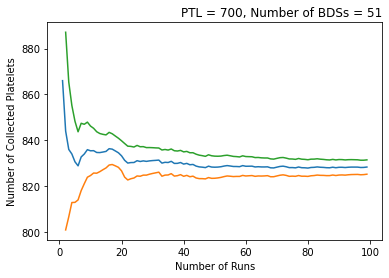

In [ ]:
Total = r21
NUM_RUNS = len(Total)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# for i in range(21):
mean =  np.array([np.mean(Total[0:i]) for i in range(NUM_RUNS)])
UB,LB = mean + 1.96*np.array([stats.sem(Total[0:i]) for i in range(NUM_RUNS)]) ,mean - 1.96*np.array([stats.sem(Total[0:i]) for i in range(NUM_RUNS)])

# plt.figure(figsize=(15, 10))
plt.figure()
plt.plot(range(NUM_RUNS), mean, label = "Mean")

plt.plot(range(NUM_RUNS), LB, label = "Lower Bound")
plt.plot(range(NUM_RUNS), UB, label = "Upper Bound")
plt.xlabel("Number of Runs")
plt.ylabel("Number of Collected Platelets")
plt.title('PTL = 700, Number of BDSs = 51', x=0.7, y=1)

print ('95%  confidence interval for the solution is :', LB[-1],UB[-1])

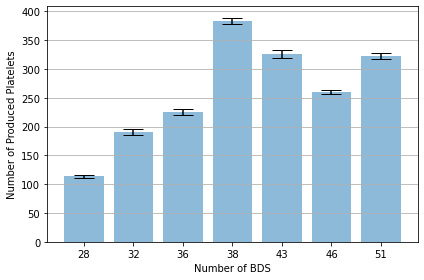

In [ ]:
# Calculate the average
r1_mean = np.mean(r1)
r2_mean = np.mean(r2)
r3_mean = np.mean(r3)
r4_mean = np.mean(r4)
r5_mean = np.mean(r5)
r6_mean = np.mean(r6)
r7_mean = np.mean(r7)

# Calculate the standard deviation
r1_std = np.std(r1)
r2_std = np.std(r2)
r3_std = np.std(r3)
r4_std = np.std(r4)
r5_std = np.std(r5)
r6_std = np.std(r6)
r7_std = np.std(r7)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
CTEs = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
error = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Number of Produced Platelets')
ax.set_xlabel('Number of BDS')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
# ax.set_title('Performance of HGA for PTL = 300')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()


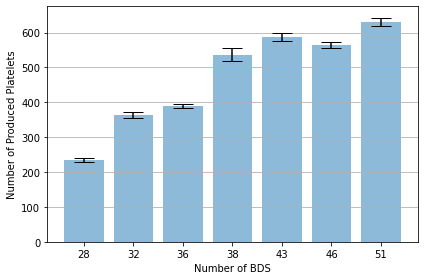

In [ ]:
# Calculate the average
r1_mean = np.mean(r8)
r2_mean = np.mean(r9)
r3_mean = np.mean(r10)
r4_mean = np.mean(r11)
r5_mean = np.mean(r12)
r6_mean = np.mean(r13)
r7_mean = np.mean(r14)

# Calculate the standard deviation
r1_std = np.std(r8)
r2_std = np.std(r9)
r3_std = np.std(r10)
r4_std = np.std(r11)
r5_std = np.std(r12)
r6_std = np.std(r13)
r7_std = np.std(r14)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
CTEs = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
error = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Number of Produced Platelets')
ax.set_xlabel('Number of BDS')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
# ax.set_title('Performance of HGA for PTL = 300')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()


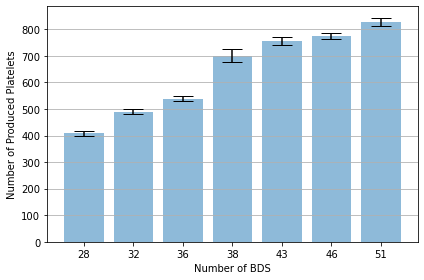

In [ ]:
# Calculate the average
r1_mean = np.mean(r15)
r2_mean = np.mean(r16)
r3_mean = np.mean(r17)
r4_mean = np.mean(r18)
r5_mean = np.mean(r19)
r6_mean = np.mean(r20)
r7_mean = np.mean(r21)

# Calculate the standard deviation
r1_std = np.std(r15)
r2_std = np.std(r16)
r3_std = np.std(r17)
r4_std = np.std(r18)
r5_std = np.std(r19)
r6_std = np.std(r20)
r7_std = np.std(r21)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
CTEs = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
error = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Number of Produced Platelets')
ax.set_xlabel('Number of BDS')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
# ax.set_title('Performance of HGA for PTL = 300')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()


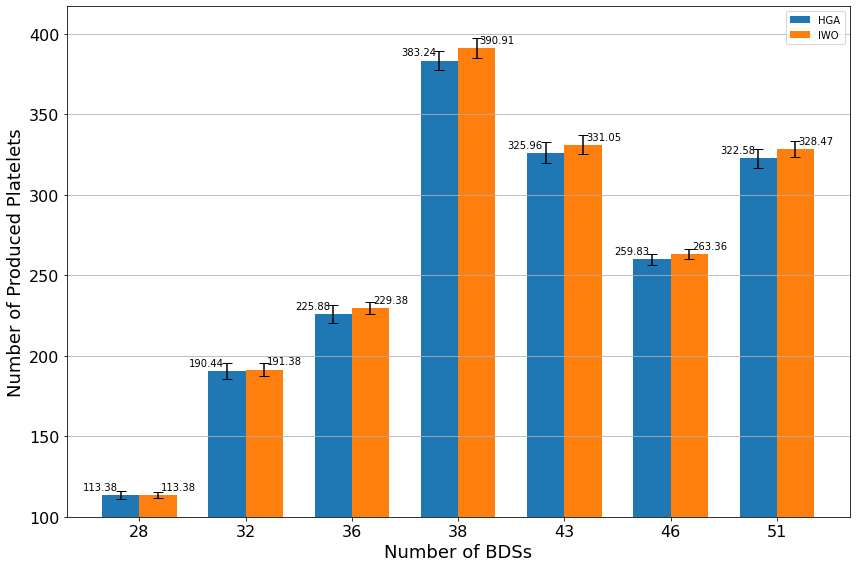

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


# Calculate the average
r1_mean = np.mean(r1)
r2_mean = np.mean(r2)
r3_mean = np.mean(r3)
r4_mean = np.mean(r4)
r5_mean = np.mean(r5)
r6_mean = np.mean(r6)
r7_mean = np.mean(r7)

# Calculate the standard deviation
r1_std = np.std(r1)
r2_std = np.std(r2)
r3_std = np.std(r3)
r4_std = np.std(r4)
r5_std = np.std(r5)
r6_std = np.std(r6)
r7_std = np.std(r7)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
men_means = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
men_std = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]


# Calculate the average
s1_mean = np.mean(s1)
s2_mean = np.mean(s2)
s3_mean = np.mean(s3)
s4_mean = np.mean(s4)
s5_mean = np.mean(s5)
s6_mean = np.mean(s6)
s7_mean = np.mean(s7)

# Calculate the standard deviation
s1_std = np.std(s1)
s2_std = np.std(s2)
s3_std = np.std(s3)
s4_std = np.std(s4)
s5_std = np.std(s5)
s6_std = np.std(s6)
s7_std = np.std(s7)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
women_means = [s1_mean,s2_mean,s3_mean,s4_mean,s5_mean,s6_mean,s7_mean]
women_std = [s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std]



# men_means, men_std = (20, 35, 30, 35, 27), (2, 3, 4, 1, 2)
# women_means, women_std = (25, 32, 34, 20, 25), (3, 5, 2, 3, 3)

ind = np.arange(len(materials))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                label='HGA',capsize=5)
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                label='IWO',capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of BDSs', fontsize=18)
ax.set_ylabel('Number of Produced Platelets', fontsize=18)
ax.set_xticks(ind)
ax.set_xticklabels([28,32,36,38,43,46,51], fontsize=16)
ax.legend()
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(bottom=100)

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")
plt.tight_layout()

# fig.tight_layout()
ax.yaxis.grid(True)

plt.show()

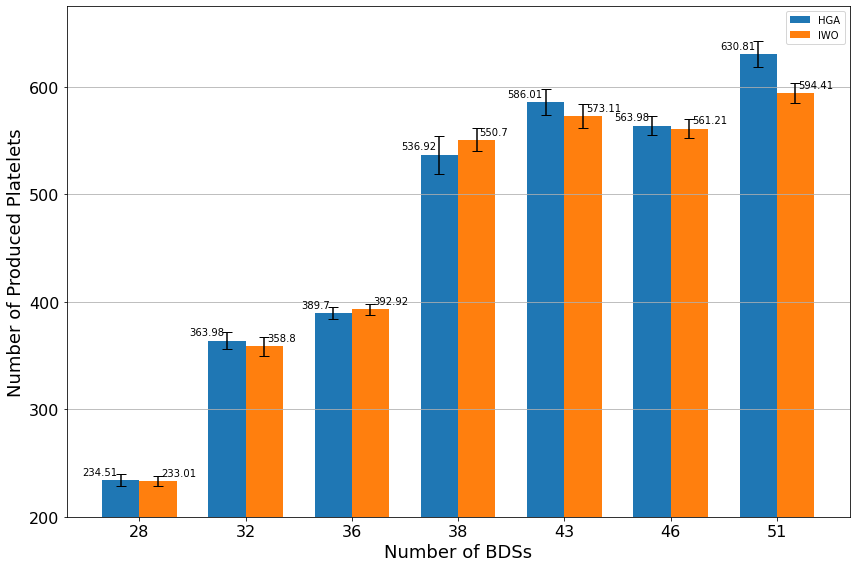

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


# Calculate the average
r1_mean = np.mean(r8)
r2_mean = np.mean(r9)
r3_mean = np.mean(r10)
r4_mean = np.mean(r11)
r5_mean = np.mean(r12)
r6_mean = np.mean(r13)
r7_mean = np.mean(r14)

# Calculate the standard deviation
r1_std = np.std(r8)
r2_std = np.std(r9)
r3_std = np.std(r10)
r4_std = np.std(r11)
r5_std = np.std(r12)
r6_std = np.std(r13)
r7_std = np.std(r14)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
men_means = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
men_std = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]


# Calculate the average
s1_mean = np.mean(s8)
s2_mean = np.mean(s9)
s3_mean = np.mean(s10)
s4_mean = np.mean(s11)
s5_mean = np.mean(s12)
s6_mean = np.mean(s13)
s7_mean = np.mean(s14)

# Calculate the standard deviation
s1_std = np.std(s8)
s2_std = np.std(s9)
s3_std = np.std(s10)
s4_std = np.std(s11)
s5_std = np.std(s12)
s6_std = np.std(s13)
s7_std = np.std(s14)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
women_means = [s1_mean,s2_mean,s3_mean,s4_mean,s5_mean,s6_mean,s7_mean]
women_std = [s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std]





# men_means, men_std = (20, 35, 30, 35, 27), (2, 3, 4, 1, 2)
# women_means, women_std = (25, 32, 34, 20, 25), (3, 5, 2, 3, 3)

ind = np.arange(len(materials))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                label='HGA',capsize=5)
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                label='IWO',capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of BDSs', fontsize=18)
ax.set_ylabel('Number of Produced Platelets', fontsize=18)
ax.set_xticks(ind)
ax.set_xticklabels([28,32,36,38,43,46,51], fontsize=16)
ax.legend()
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(bottom=200)

# # Plot the bar chart with the y-axis starting at 5
# ax.bar(x_values, y_values, bottom=5)

# Set the y-axis limits to start at 5


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")
plt.tight_layout()

# fig.tight_layout()
ax.yaxis.grid(True)

plt.show()

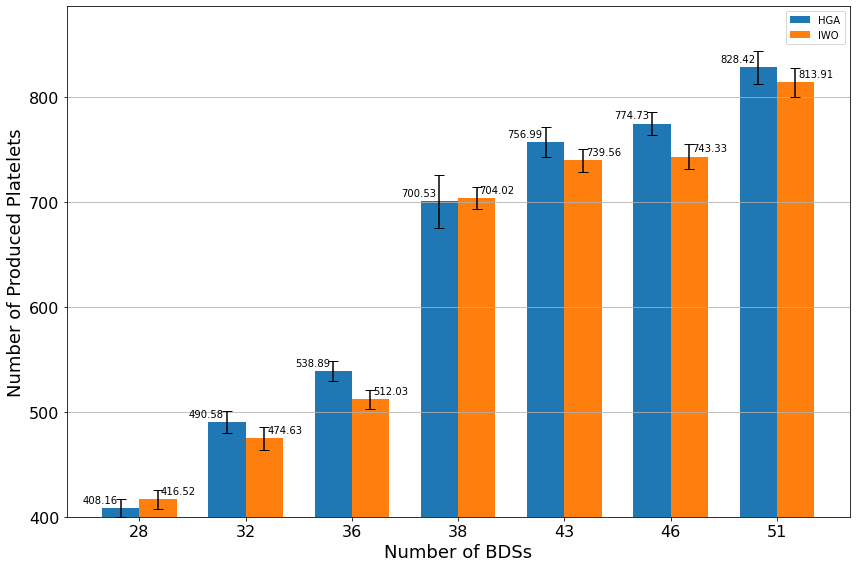

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average
r1_mean = np.mean(r15)
r2_mean = np.mean(r16)
r3_mean = np.mean(r17)
r4_mean = np.mean(r18)
r5_mean = np.mean(r19)
r6_mean = np.mean(r20)
r7_mean = np.mean(r21)

# Calculate the standard deviation
r1_std = np.std(r15)
r2_std = np.std(r16)
r3_std = np.std(r17)
r4_std = np.std(r18)
r5_std = np.std(r19)
r6_std = np.std(r20)
r7_std = np.std(r21)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
men_means = [r1_mean,r2_mean,r3_mean,r4_mean,r5_mean,r6_mean,r7_mean]
men_std = [r1_std,r2_std,r3_std,r4_std,r5_std,r6_std,r7_std]

# Calculate the average
s1_mean = np.mean(s15)
s2_mean = np.mean(s16)
s3_mean = np.mean(s17)
s4_mean = np.mean(s18)
s5_mean = np.mean(s19)
s6_mean = np.mean(s20)
s7_mean = np.mean(s21)

# Calculate the standard deviation
s1_std = np.std(s15)
s2_std = np.std(s16)
s3_std = np.std(s17)
s4_std = np.std(s18)
s5_std = np.std(s19)
s6_std = np.std(s20)
s7_std = np.std(s21)

# Create lists for the plot
materials = [28,32,36,38,43,46,51]
x_pos = np.arange(len(materials))
women_means = [s1_mean,s2_mean,s3_mean,s4_mean,s5_mean,s6_mean,s7_mean]
women_std = [s1_std,s2_std,s3_std,s4_std,s5_std,s6_std,s7_std]


# men_means, men_std = (20, 35, 30, 35, 27), (2, 3, 4, 1, 2)
# women_means, women_std = (25, 32, 34, 20, 25), (3, 5, 2, 3, 3)

ind = np.arange(len(materials))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                label='HGA',capsize=5)
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                label='IWO',capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of BDSs', fontsize=18)
ax.set_ylabel('Number of Produced Platelets', fontsize=18)
ax.set_xticks(ind)
ax.set_xticklabels([28,32,36,38,43,46,51], fontsize=16)
ax.legend()
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(bottom=400)

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

autolabel(rects1, "left")
autolabel(rects2, "right")
plt.tight_layout()

# fig.tight_layout()
ax.yaxis.grid(True)

plt.show()

In [ ]:
df9 = pd.read_csv("/Users/raminkhameneh/Desktop/HM.csv")

# HM = df9.values.tolist()
df9

temp1 = [[0.591919,0.686421,0.496165,0.499555],[0.306545,0.025650,0.622316,-0.345683],[-0.727242,-0.752511,0.226036,0.523864]]
temp2 = [[0.633747,0.734055,0.718580,0.949758],[0.901720,0.862071,0.741920,0.970627],[0.957161,0.981284,0.873436,0.876049]]
temp3 = [[0.976156,0.955095,0.171089,0.752936],[0.981744,0.937059,0.660514,0.921586],[0.922748,0.929197,0.879891,0.920289]]

a = np.array([np.array(xi) for xi in temp3])

%matplotlib inline

Index= ['300','500','700']
Cols = ['HGA','IWO','SRGH','SGH']
df = pd.DataFrame(a, index=Index, columns=Cols)
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(df, vmin=-1, vmax=1, annot=True)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/raminkhameneh/Desktop/HM.csv'

<AxesSubplot:xlabel='Mutation Rate', ylabel='Mutation Volume'>

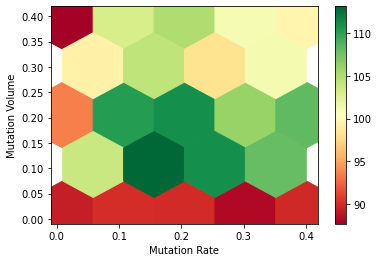

In [ ]:
import pandas as pd
outputs = [(0.01, 0.01, 89.3),(0.01, 0.1, 94.1), (0.01, 0.2, 93.5), (0.01, 0.3, 92.6), (0.01, 0.4, 87.7),
          (0.1, 0.01, 90.1),(0.1, 0.1, 113.3), (0.1, 0.2, 110.2), (0.1, 0.3, 106), (0.1, 0.4, 103),
          (0.2, 0.01, 90.0),(0.2, 0.1, 113.1), (0.2, 0.2, 111), (0.2, 0.3, 104.2), (0.2, 0.4, 105),
          (0.3, 0.01, 88.2),(0.3, 0.1, 111), (0.3, 0.2, 106), (0.3, 0.3, 98.2), (0.3, 0.4, 101),
          (0.4, 0.01, 89.8),(0.4, 0.1, 108), (0.4, 0.2, 108.2), (0.4, 0.3, 101.1), (0.4, 0.4, 99.6)]

# fig, ax = plt.subplots(figsize=(8, 6))

df = pd.DataFrame(outputs, columns=['Mutation Rate', 'Mutation Volume', 'y'])
df.style.background_gradient(subset='y', cmap='RdYlGn')
df.plot.hexbin(x='Mutation Rate', y='Mutation Volume', C='y', gridsize=4, cmap='RdYlGn', sharex=False)

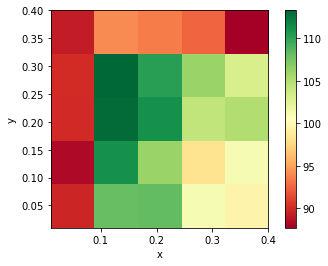

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the x, y, and z values from the list of tuples
x = [t[0] for t in outputs]
y = [t[1] for t in outputs]
z = [t[2] for t in outputs]

# Create a grid of x and y values
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Reshape z values to match the grid
Z = np.reshape(z, (len(np.unique(y)), len(np.unique(x))))

# Plot the heatmap
plt.imshow(Z, cmap='RdYlGn', interpolation='nearest', extent=[min(x), max(x), min(y), max(y)])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

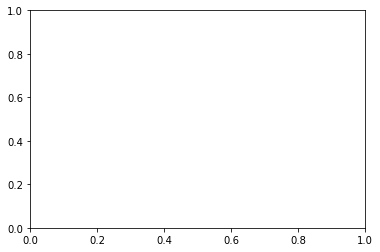

In [ ]:
import pylab as plt
import numpy as np

x = []
y = []
Z = []

for tup in outputs:
    x.append(tup[0])
    y.append(tup[1])
    Z.append(tup[2])

# x = np.arange(10)  # len = 10
# y = np.arange(6)  # len = 6
X, Y = np.meshgrid(x, y)

# Sample data
# side = np.linspace(-2,2,15)
# X,Y = np.meshgrid(side,side)
# Z = np.exp(-((X-1)**2+Y**2))

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()
# np.linspace(-2,2,15)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Extract x, y, and density values from the list of tuples
x = [t[0] for t in list]
y = [t[1] for t in list]
density = [t[2] for t in list]

# Create a color map from the density values
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(density)

# Create the scatter plot
plt.scatter(x, y, c=colors, s=50)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Density Scatter Plot')
plt.show()

TypeError: 'type' object is not iterable

In [ ]:
np.random.seed(19680801)
Z = np.random.rand(6, 10)
x = np.arange(-0.5, 10, 1)  # len = 11
y = np.arange(4.5, 11, 1)  # len = 7

# fig, ax = plt.subplots()
# ax.pcolormesh(x, y, Z)
Y

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 ],
       [0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
        0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
        0.2 , 0.2 , 0.2 ],
       [0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
        0.3 , 0.3 , 0.3 ],
       [0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ,
        0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ,
        0.4 , 0.4 , 0.4 ],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0